## Challenge

In this module, you learned how to approach and solve regression problems using linear regression models. Throughout the module, you worked on a houseprices dataset from Kaggle. In this challenge, you will keep working on this dataset.
The scenario

The housing market is one of the most crucial parts of every country's economy. Purchasing a home is one of the primary ways to build wealth and savings for people. In this respect, predicting prices in the housing market is a central topic in economic and financial circles.

The houseprices dataset from Kaggle includes several features of the houses, along with their sale prices at the time that they are sold. So far in this module, you have built and implemented some models using this dataset.

In this challenge, you are required to improve your model with respect to its prediction performance.

To complete this challenge, submit a Jupyter Notebook containing your solutions to the following tasks.
Steps

1. Load the houseprices data from Thinkful's database.
2. Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But, make sure that your work is satisfactory.
3. Now, split your data into train and test sets where 20% of the data resides in the test set.
4. Build several linear regression models including lasso, ridge, or elastic net, and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one.
5. Evaluate your best model on the test set.
6. So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.


## Load datasets

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
import seaborn as sns
from sqlalchemy import create_engine

%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action='ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houseprices_df = pd.read_sql_query('SELECT * FROM houseprices', con=engine)
financial_indicators_df = pd.read_csv('https://github.com/mmcintire00/houseprices_lrm/blob/main/federal-reserve-interest-rates.csv?raw=true') # Kaggle dataset of federal reserve interest rates, gdp growth/decline, unemployment

engine.dispose()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data cleaning, exploratory analysis, and feature engineering



In [ ]:
houseprices_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,...,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000


In [ ]:
houseprices_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 1459
Data columns (total 89 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            1460 non-null   int64  
 1   mssubclass                    1460 non-null   int64  
 2   mszoning                      1460 non-null   object 
 3   lotfrontage                   1201 non-null   float64
 4   lotarea                       1460 non-null   int64  
 5   street                        1460 non-null   object 
 6   alley                         91 non-null     object 
 7   lotshape                      1460 non-null   object 
 8   landcontour                   1460 non-null   object 
 9   utilities                     1460 non-null   object 
 10  lotconfig                     1460 non-null   object 
 11  landslope                     1460 non-null   object 
 12  neighborhood                  1460 non-null   object 
 13  con

In [ ]:
houseprices_df.shape

(1460, 81)

In [ ]:
null_list =(houseprices_df.isnull().sum()*100)/(houseprices_df.isnull().count())
null_list.head(25)

id              0.000
mssubclass      0.000
mszoning        0.000
lotfrontage    17.740
lotarea         0.000
street          0.000
alley          93.767
lotshape        0.000
landcontour     0.000
utilities       0.000
lotconfig       0.000
landslope       0.000
neighborhood    0.000
condition1      0.000
condition2      0.000
bldgtype        0.000
housestyle      0.000
overallqual     0.000
overallcond     0.000
yearbuilt       0.000
yearremodadd    0.000
roofstyle       0.000
roofmatl        0.000
exterior1st     0.000
exterior2nd     0.000
dtype: float64

In [ ]:
# list of years in the dataset
year_list = houseprices_df['yrsold'].unique()
print(year_list)

[2008 2007 2006 2009 2010]


In [ ]:
# separate variables by categorical values and numerical values
cat_columns = houseprices_df.select_dtypes(['object']).columns
num_columns = houseprices_df.select_dtypes(['int64', 'float64'])
num_columns = num_columns.drop(columns=['id'])
num_columns.head()

,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
0,60,65.000,8450,7,5,2003,2003,196.000,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.000,2,548,0,61,0,0,0,0,0,2,2008,208500
1,20,80.000,9600,6,8,1976,1976,0.000,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.000,2,460,298,0,0,0,0,0,0,5,2007,181500
2,60,68.000,11250,7,5,2001,2002,162.000,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.000,2,608,0,42,0,0,0,0,0,9,2008,223500
3,70,60.000,9550,7,5,1915,1970,0.000,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.000,3,642,0,35,272,0,0,0,0,2,2006,140000
4,60,84.000,14260,8,5,2000,2000,350.000,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.000,3,836,192,84,0,0,0,0,0,12,2008,250000


In [ ]:
# number of numerical values minus 'id'
print(num_columns.shape[1])

37


In [ ]:
# correlation of variables with salesprices
corr_with_saleprice = houseprices_df.corrwith(houseprices_df['saleprice']).sort_values(ascending=False)
print(corr_with_saleprice)

saleprice        1.000
overallqual      0.791
grlivarea        0.709
garagecars       0.640
garagearea       0.623
totalbsmtsf      0.614
firstflrsf       0.606
fullbath         0.561
totrmsabvgrd     0.534
yearbuilt        0.523
yearremodadd     0.507
garageyrblt      0.486
masvnrarea       0.477
fireplaces       0.467
bsmtfinsf1       0.386
lotfrontage      0.352
wooddecksf       0.324
secondflrsf      0.319
openporchsf      0.316
halfbath         0.284
lotarea          0.264
bsmtfullbath     0.227
bsmtunfsf        0.214
bedroomabvgr     0.168
screenporch      0.111
poolarea         0.092
mosold           0.046
threessnporch    0.045
bsmtfinsf2      -0.011
bsmthalfbath    -0.017
miscval         -0.021
id              -0.022
lowqualfinsf    -0.026
yrsold          -0.029
overallcond     -0.078
mssubclass      -0.084
enclosedporch   -0.129
kitchenabvgr    -0.136
dtype: float64


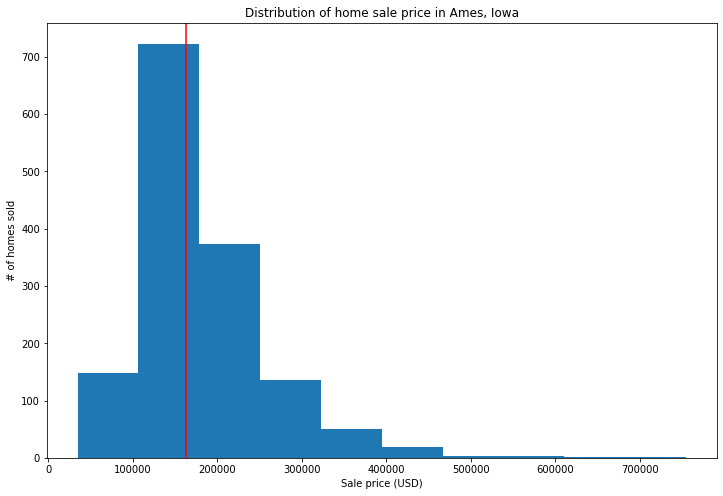

In [ ]:
# price distribution of salesprice in ames, iowa
plt.figure(figsize=(12,8))
plt.hist(houseprices_df['saleprice'])
plt.axvline(houseprices_df['saleprice'].median(), color='r')
plt.ylabel('# of homes sold')
plt.xlabel('Sale price (USD)')
plt.title('Distribution of home sale price in Ames, Iowa')
plt.show()

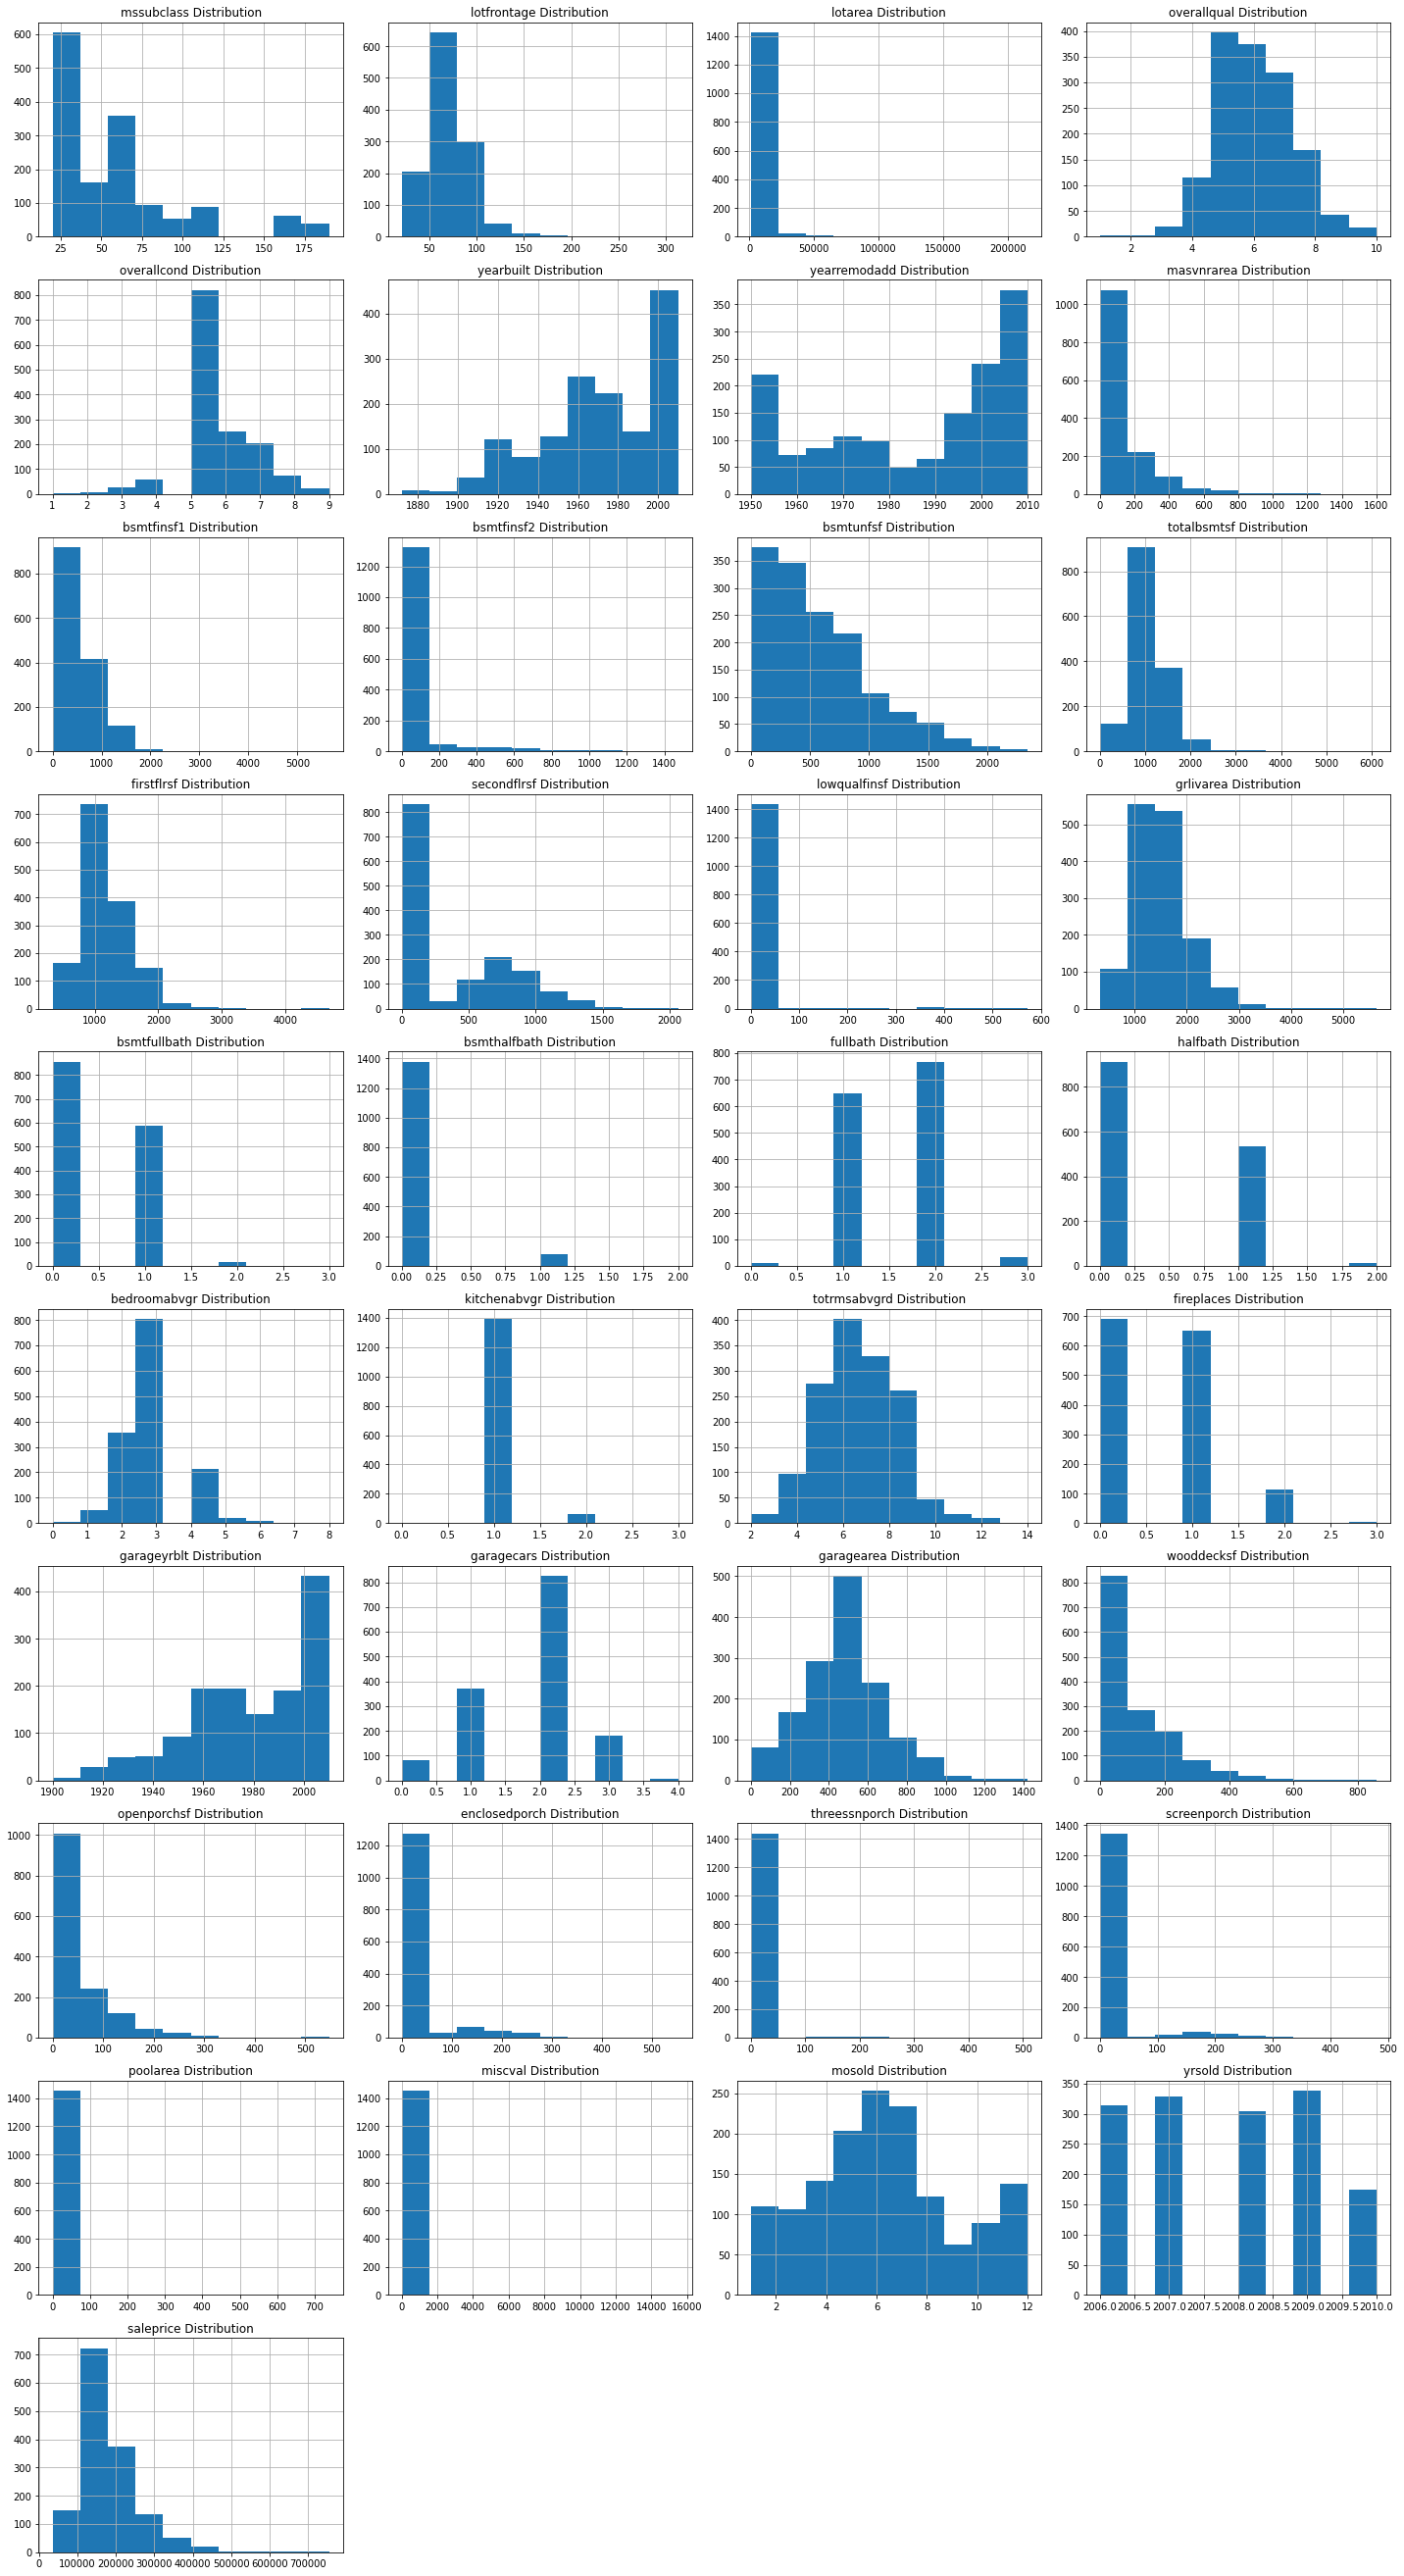

In [ ]:
# histograms for numerical datasets
def draw_histograms(df, variables, n_rows, n_cols):
  fig=plt.figure(figsize=(20,40))
  for i, var_name in enumerate(variables):
    ax=fig.add_subplot(n_rows, n_cols, i+1)
    df[var_name].hist(ax=ax)
    ax.set_title(var_name + ' Distribution')
  fig.tight_layout()
  plt.show()

draw_histograms(num_columns, num_columns.columns, 11, 4)

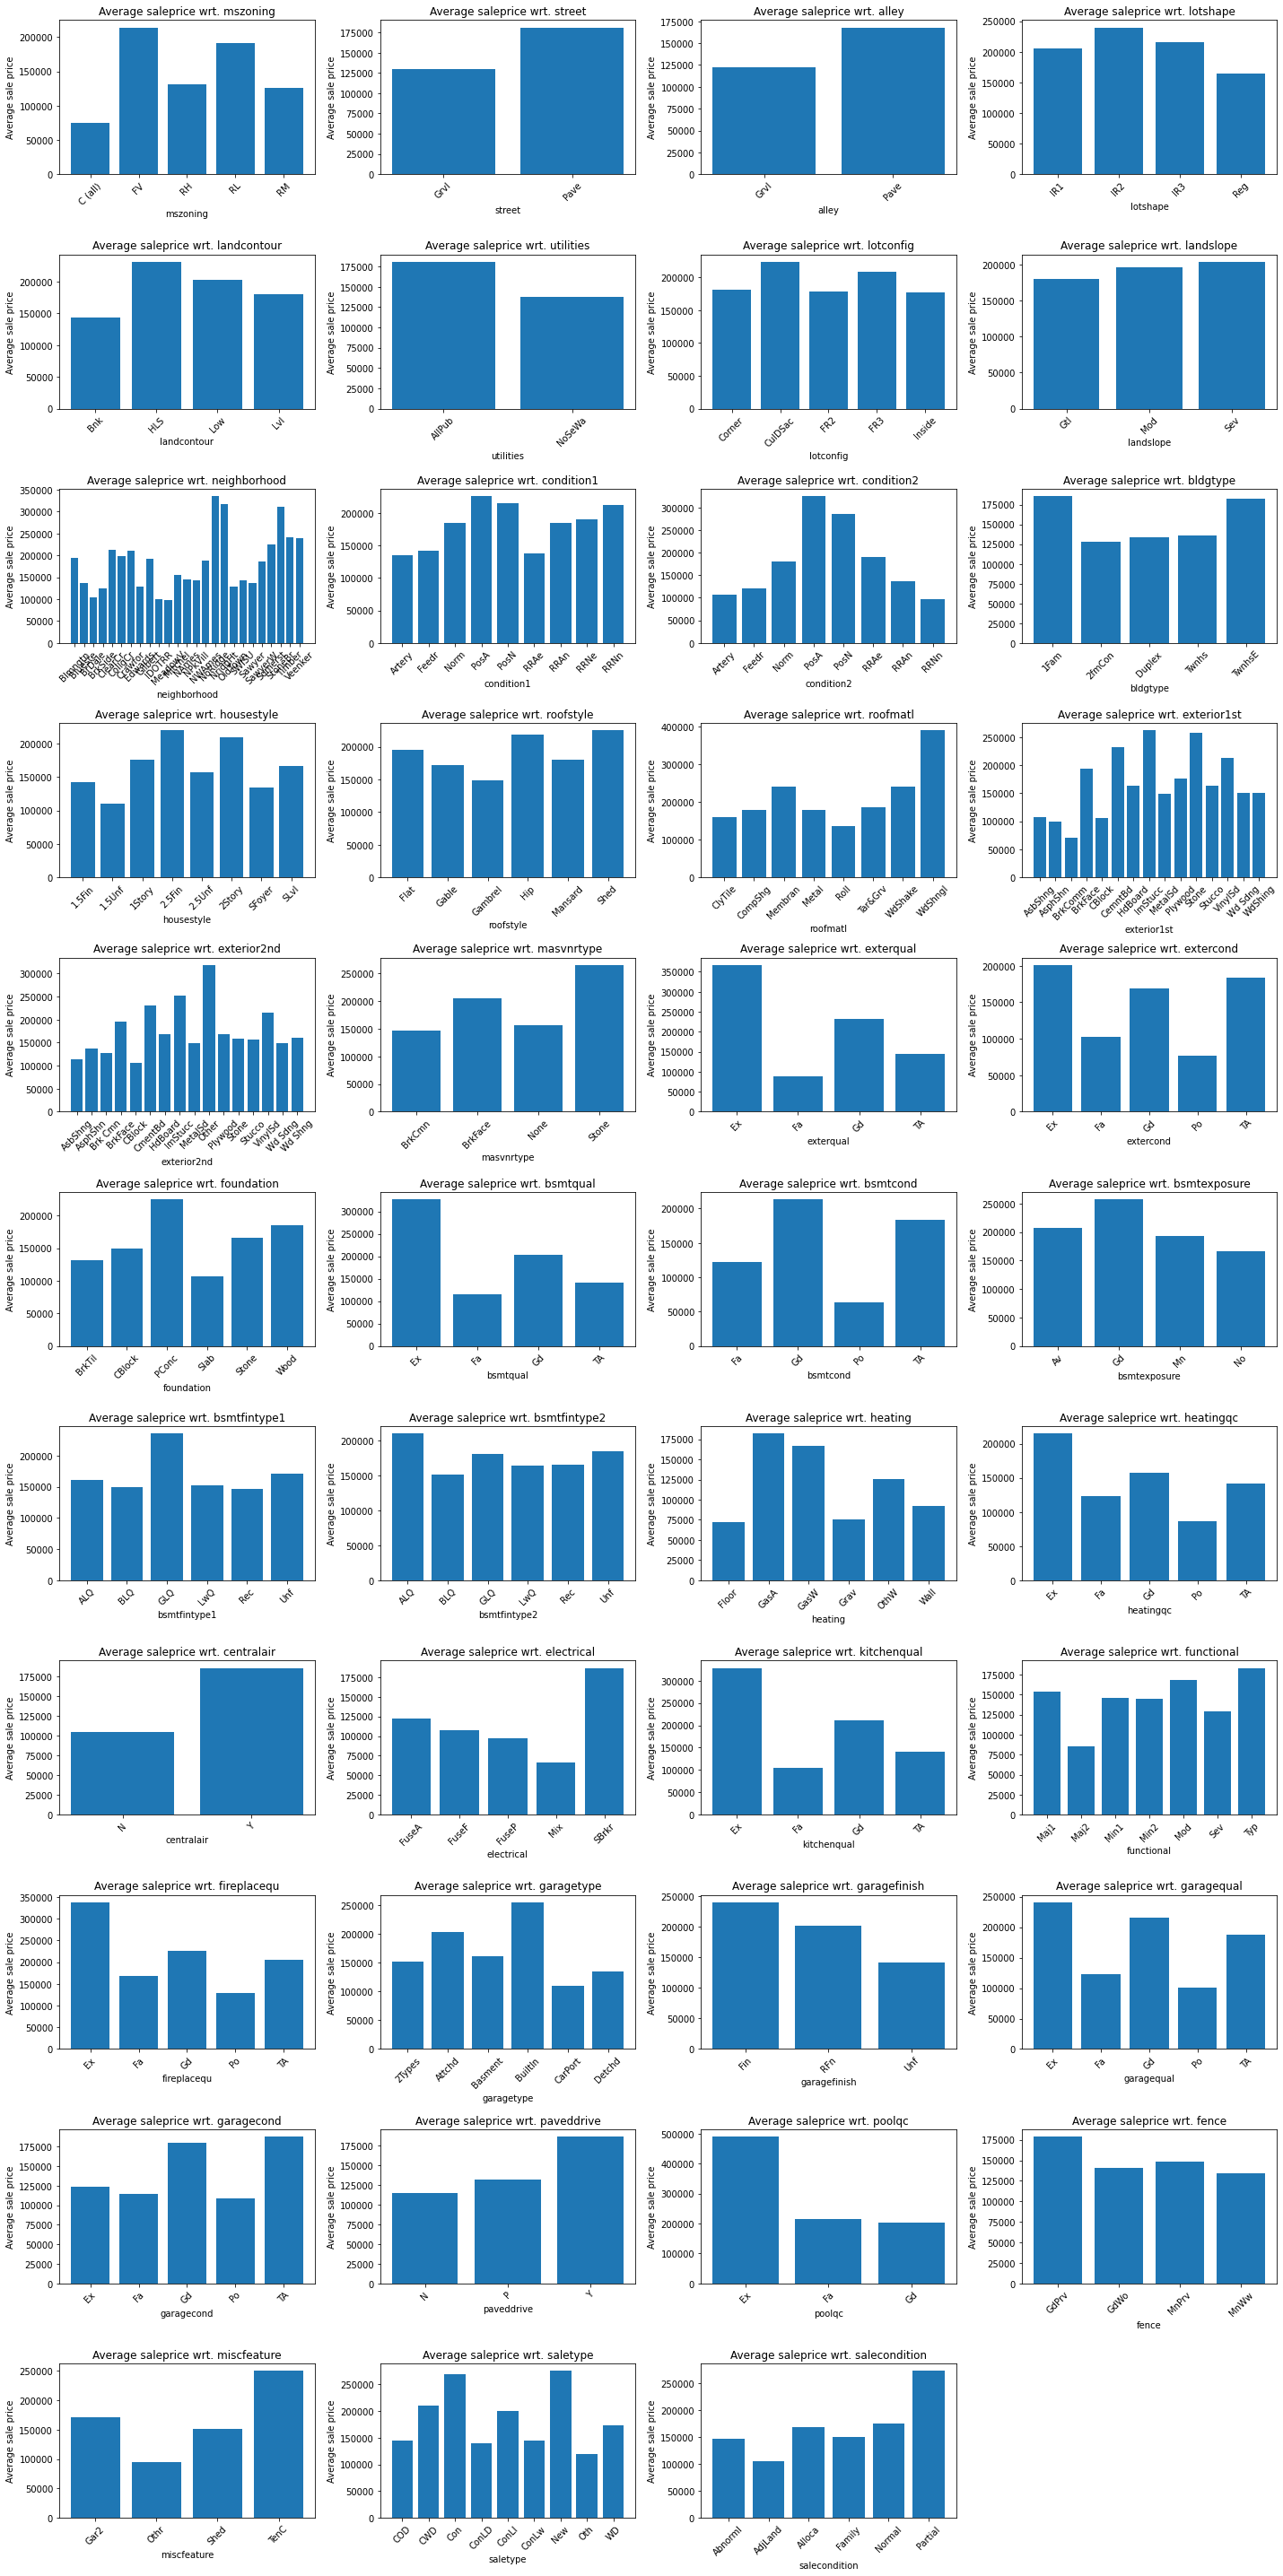

In [ ]:
# bar charts for categorical data
plt.figure(figsize=(20,40))

for index, column in enumerate(cat_columns):
  plt.subplot(11,4,index+1)
  plt.bar(houseprices_df.groupby(column)['saleprice'].mean().index, houseprices_df.groupby(column)['saleprice'].mean())
  plt.title('Average saleprice wrt. {}'.format(column))
  plt.ylabel('Average sale price')
  plt.xlabel(column)
  plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
#create dummy for the centralair variable
houseprices_df = pd.concat([houseprices_df, pd.get_dummies(houseprices_df['centralair'], prefix='centralair', drop_first=True)], axis=1) # central air dummy variable

dummy_names = list(pd.get_dummies(houseprices_df['centralair'], prefix='centralair', drop_first=True).columns)

#create new feauture for totalsf by adding all sf values
houseprices_df['totalsf'] = houseprices_df['firstflrsf'] + houseprices_df['secondflrsf'] + houseprices_df['totalbsmtsf'] # home total square footage

houseprices_df['garagecars_area_inter'] = houseprices_df['garagecars'] * houseprices_df['garagearea'] # garage cars and area interaction variable

houseprices_df['overall_yearbuilt_inter'] = houseprices_df['yearbuilt'] * houseprices_df['overallqual'] # yearbuilt and quality of home interaction variable

## Regression models (OLS, Ridge, Lasso, Elastic)

In [ ]:
#split data into features(X) and target (Y)
X = houseprices_df[['overallqual', 'grlivarea', 'fullbath', 'totalsf', 'garagecars_area_inter', 'overall_yearbuilt_inter'] + dummy_names]
Y = np.log1p(houseprices_df.saleprice)

# add constant
X = sm.add_constant(X)

# split into test and train data
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state=465)

# this is to determine the best alpha to use for Ridge, Lasso, and Elastic regressions
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

OLS regression

In [ ]:
# ols regression model
lrm = LinearRegression()
lrm.fit(X_train, y_train)

# predictions
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print('Training set R-squared: {}'.format(lrm.score(X_train, y_train)))
print('Test set R-squared: {}'.format(lrm.score(X_test, y_test)))
print('MAE of the prediction is: {}'.format(mean_absolute_error(y_test, y_preds_test)))
print('MSE of the prediction is: {}'.format(mse(y_test, y_preds_test)))
print('RMSE of the prediction is: {}'.format(rmse(y_test, y_preds_test)))
print('MAPE of the prediction is: {}'.format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Training set R-squared: 0.8085309395543968
Test set R-squared: 0.8419848638318628
MAE of the prediction is: 0.11565336612346477
MSE of the prediction is: 0.026348336403246457
RMSE of the prediction is: 0.16232170650669756
MAPE of the prediction is: 0.9674483045927983


Ridge regression

In [ ]:
ridgecv = RidgeCV(alphas=alphas, cv=10)
ridgecv.fit(X_train, y_train)

#predictions
y_preds_train = ridgecv.predict(X_train)
y_preds_test = ridgecv.predict(X_test)

print('Best alpha value: {}'.format(ridgecv.alpha_))
print('Training set R-squared: {}'.format(ridgecv.score(X_train, y_train)))
print('Test set R-squared: {}'.format(ridgecv.score(X_test, y_test)))
print('MAE of the prediction is: {}'.format(mean_absolute_error(y_test, y_preds_test)))
print('MSE of the prediction is: {}'.format(mse(y_test, y_preds_test)))
print('RMSE of the prediction is: {}'.format(rmse(y_test, y_preds_test)))
print('MAPE of the prediction is: {}'.format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value: 1.0
Training set R-squared: 0.8084316787669688
Test set R-squared: 0.8405583696812673
MAE of the prediction is: 0.11643112767578892
MSE of the prediction is: 0.026586198095921016
RMSE of the prediction is: 0.163052746361173
MAPE of the prediction is: 0.9740092474587769


Lasso

In [ ]:
lassocv = LassoCV(alphas=alphas, cv=10)
lassocv.fit(X_train, y_train)

#predictions
y_preds_train = lassocv.predict(X_train)
y_preds_test = lassocv.predict(X_test)

print('Best alpha value: {}'.format(lassocv.alpha_))
print('Training set R-squared: {}'.format(lassocv.score(X_train, y_train)))
print('Test set R-squared: {}'.format(lassocv.score(X_test, y_test)))
print('MAE of the prediction is: {}'.format(mean_absolute_error(y_test, y_preds_test)))
print('MSE of the prediction is: {}'.format(mse(y_test, y_preds_test)))
print('RMSE of the prediction is: {}'.format(rmse(y_test, y_preds_test)))
print('MAPE of the prediction is: {}'.format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value: 1e-05
Training set R-squared: 0.8083890407060822
Test set R-squared: 0.8403443484854032
MAE of the prediction is: 0.11657760772948161
MSE of the prediction is: 0.026621885199085923
RMSE of the prediction is: 0.16316214389093422
MAPE of the prediction is: 0.9752093647544307


Elastic Net

In [ ]:
elastic_cv = ElasticNetCV(alphas=alphas, cv=10)
elastic_cv.fit(X_train, y_train)

# predictions 
y_preds_train = elastic_cv.predict(X_train)
y_preds_test = elastic_cv.predict(X_test)

print('Best alpha value: {}'.format(lassocv.alpha_))
print('Training set R-squared: {}'.format(lassocv.score(X_train, y_train)))
print('Test set R-squared: {}'.format(lassocv.score(X_test, y_test)))
print('MAE of the prediction is: {}'.format(mean_absolute_error(y_test, y_preds_test)))
print('MSE of the prediction is: {}'.format(mse(y_test, y_preds_test)))
print('RMSE of the prediction is: {}'.format(rmse(y_test, y_preds_test)))
print('MAPE of the prediction is: {}'.format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value: 1e-05
Training set R-squared: 0.8083890407060822
Test set R-squared: 0.8403443484854032
MAE of the prediction is: 0.11671634542654852
MSE of the prediction is: 0.026659722572008583
RMSE of the prediction is: 0.1632780529404016
MAPE of the prediction is: 0.9763703005640587


I would likely use the OLS regression model. All of the models seem to be equivalent. 

## 6. Additional variables:

I pulled this data from Kaggle. It is a dataset that contains interest rates, gdp data (recession indicator), unemployment, and inflation.

In [ ]:
# house prices data between 2006 and 2010. Filter financial data to these years
financial_data_06_10_df = financial_indicators_df[financial_indicators_df['Year'].between(2006,2010)]
financial_data_06_10_df = financial_data_06_10_df.rename(columns={'Year':'yrsold'}) # change Year to yrsold (houseprices_df) for merge

In [ ]:
grouped_financial_df = financial_data_06_10_df.groupby(['yrsold'], as_index=False).mean() # group data by year and determine the average interest rate
grouped_financial_df = grouped_financial_df.drop(columns=['Month', 'Day', 'Federal Funds Target Rate', 'Federal Funds Upper Target', 'Federal Funds Lower Target']) # drop un-needed columns for cleanliness
grouped_financial_df.head()

,yrsold,Effective Federal Funds Rate,Real GDP (Percent Change),Unemployment Rate,Inflation Rate
0,2006,4.964,2.425,4.608,2.492
1,2007,5.019,1.850,4.617,2.325
2,2008,1.927,-2.700,5.800,2.308
3,2009,0.160,-0.175,9.283,1.692
4,2010,0.175,2.700,9.608,0.958


In [ ]:
houseprices_df = pd.merge(houseprices_df, grouped_financial_df, on='yrsold', how='left') # left outer join financial data with houseprices data.
houseprices_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,...,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice,centralair_Y,totalsf,garagecars_area_inter,overall_yearbuilt_inter,Effective Federal Funds Rate,Real GDP (Percent Change),Unemployment Rate,Inflation Rate
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500,1,2566,1096,14021,1.927,-2.700,5.800,2.308
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500,1,2524,920,11856,5.019,1.850,4.617,2.325
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500,1,2706,1216,14007,1.927,-2.700,5.800,2.308
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000,1,2473,1926,13405,4.964,2.425,4.608,2.492
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000,1,3343,2508,16000,1.927,-2.700,5.800,2.308


In [ ]:
selected_hp_features = houseprices_df[['yrsold', 'saleprice', 'overallqual', 'grlivarea', 'fullbath', 'totalsf', 'garagecars_area_inter', 'overall_yearbuilt_inter', 'Effective Federal Funds Rate', 'Real GDP (Percent Change)', 'Unemployment Rate', 'Inflation Rate'] + dummy_names] # important features (taken from models above) for the model
selected_hp_features.head()

,yrsold,saleprice,overallqual,grlivarea,fullbath,totalsf,garagecars_area_inter,overall_yearbuilt_inter,Effective Federal Funds Rate,Real GDP (Percent Change),Unemployment Rate,Inflation Rate,centralair_Y
0,2008,208500,7,1710,2,2566,1096,14021,1.927,-2.700,5.800,2.308,1
1,2007,181500,6,1262,2,2524,920,11856,5.019,1.850,4.617,2.325,1
2,2008,223500,7,1786,2,2706,1216,14007,1.927,-2.700,5.800,2.308,1
3,2006,140000,7,1717,1,2473,1926,13405,4.964,2.425,4.608,2.492,1
4,2008,250000,8,2198,2,3343,2508,16000,1.927,-2.700,5.800,2.308,1


Text(0.5, 1.0, 'Correlation of features in house prices model')

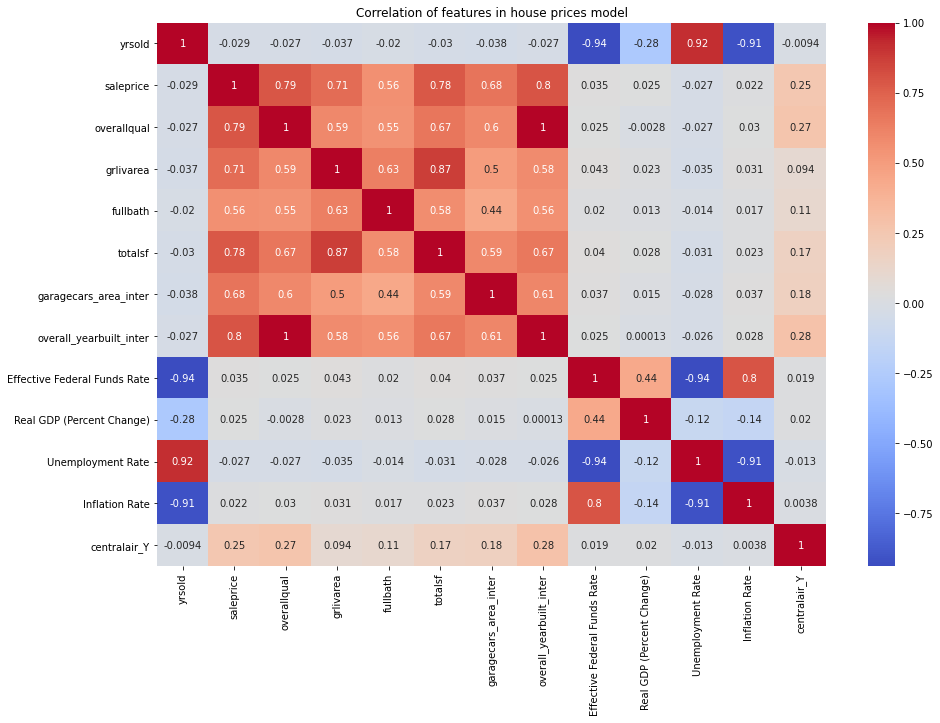

In [ ]:
# correlation heatmap using seaborn for features in the model
plt.figure(figsize=(15,10))
sns.heatmap(selected_hp_features.corr(), cbar=True, cmap='coolwarm', annot=True)
plt.title('Correlation of features in house prices model')

In [ ]:
# Split data into features (X) and target variable (Y)
X = houseprices_df[['yrsold', 'overallqual', 'grlivarea', 'fullbath', 'totalsf', 'garagecars_area_inter', 'overall_yearbuilt_inter', 'Unemployment Rate', 'Inflation Rate',  'Effective Federal Funds Rate', 'Real GDP (Percent Change)'] + dummy_names]
Y = np.log1p(houseprices_df.saleprice)

# always add a contant!
X = sm.add_constant(X)

#split data into training and testing datar
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state=465)

In [ ]:
# ols regression model
lrm = LinearRegression()
lrm.fit(X_train, y_train)

# predictions
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print('Training set R-squared: {}'.format(lrm.score(X_train, y_train)))
print('Test set R-squared: {}'.format(lrm.score(X_test, y_test)))
print('MAE of the prediction is: {}'.format(mean_absolute_error(y_test, y_preds_test)))
print('MSE of the prediction is: {}'.format(mse(y_test, y_preds_test)))
print('RMSE of the prediction is: {}'.format(rmse(y_test, y_preds_test)))
print('MAPE of the prediction is: {}'.format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Training set R-squared: 0.8086769118389446
Test set R-squared: 0.8419461855656545
MAE of the prediction is: 0.11552334028433645
MSE of the prediction is: 0.026354785835840455
RMSE of the prediction is: 0.1623415714961527
MAPE of the prediction is: 0.96643985828467


In [ ]:
# ridge cross validation model
ridgecv = RidgeCV(alphas=alphas, cv=5) # alphas evaluated from -10 to 40 by 1; cross validation has fold of 5
ridgecv.fit(X_train, y_train)

#predictions
y_preds_train = ridgecv.predict(X_train)
y_preds_test = ridgecv.predict(X_test)

print('Best alpha value: {}'.format(ridgecv.alpha_))
print('Training set R-squared: {}'.format(ridgecv.score(X_train, y_train)))
print('Test set R-squared: {}'.format(ridgecv.score(X_test, y_test)))
print('MAE of the prediction is: {}'.format(mean_absolute_error(y_test, y_preds_test)))
print('MSE of the prediction is: {}'.format(mse(y_test, y_preds_test)))
print('RMSE of the prediction is: {}'.format(rmse(y_test, y_preds_test)))
print('MAPE of the prediction is: {}'.format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value: 1.0
Training set R-squared: 0.8085754276013121
Test set R-squared: 0.8405086686591448
MAE of the prediction is: 0.11636219957035251
MSE of the prediction is: 0.02659448552510168
RMSE of the prediction is: 0.1630781577192411
MAPE of the prediction is: 0.9734864435208067


In [ ]:
#lasso cross validation model
lassocv = LassoCV(alphas=alphas, cv=5) # alphas evaluated from -10 to 40 by 1; cross validation has fold of 5
lassocv.fit(X_train, y_train)

#predictions
y_preds_train = lassocv.predict(X_train)
y_preds_test = lassocv.predict(X_test)

print('Best alpha value: {}'.format(lassocv.alpha_))
print('Training set R-squared: {}'.format(lassocv.score(X_train, y_train)))
print('Test set R-squared: {}'.format(lassocv.score(X_test, y_test)))
print('MAE of the prediction is: {}'.format(mean_absolute_error(y_test, y_preds_test)))
print('MSE of the prediction is: {}'.format(mse(y_test, y_preds_test)))
print('RMSE of the prediction is: {}'.format(rmse(y_test, y_preds_test)))
print('MAPE of the prediction is: {}'.format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value: 0.0001
Training set R-squared: 0.8084673619230837
Test set R-squared: 0.8397814878495111
MAE of the prediction is: 0.11681582151963936
MSE of the prediction is: 0.026715739761011235
RMSE of the prediction is: 0.1634495021742533
MAPE of the prediction is: 0.9772483695479849


In [ ]:
# elastic cross validation model
elastic_cv = ElasticNetCV(alphas=alphas, cv=5) # alphas evaluated from -10 to 40 by 1; cross validation has fold of 5
elastic_cv.fit(X_train, y_train)

# predictions 
y_preds_train = elastic_cv.predict(X_train)
y_preds_test = elastic_cv.predict(X_test)

print('Best alpha value: {}'.format(lassocv.alpha_))
print('Training set R-squared: {}'.format(lassocv.score(X_train, y_train)))
print('Test set R-squared: {}'.format(lassocv.score(X_test, y_test)))
print('MAE of the prediction is: {}'.format(mean_absolute_error(y_test, y_preds_test)))
print('MSE of the prediction is: {}'.format(mse(y_test, y_preds_test)))
print('RMSE of the prediction is: {}'.format(rmse(y_test, y_preds_test)))
print('MAPE of the prediction is: {}'.format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value: 0.0001
Training set R-squared: 0.8084673619230837
Test set R-squared: 0.8397814878495111
MAE of the prediction is: 0.11669454490306004
MSE of the prediction is: 0.026683437018412616
RMSE of the prediction is: 0.16335065662069626
MAPE of the prediction is: 0.9762351042217898


Discussion: The best model appears to still be the OLS regression. I don't believe that additional features are having a significant effect on the model. I do think they play a large role in in the saleprice of homes. Could the reason these features are not playing a significant role be becuase of the way i've used them in the data. The financial indicators were originally reported by month and there is not a specific date of sale for the homes price. To import this data i took the average value for each year and joined with the saleprice data by 'yrsold'. There might be a greater effect of these features if we could tie the sale price to a specific date to get a better sense of interest rates and other factors at the time of purchase.